In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
mpl.rc('font', family='Malgun Gothic')

In [ ]:
df_member = pd.read_csv('Member_Data.csv', encoding='EUC-KR')
df_product = pd.read_csv('Product_Data.csv')
df_sales = pd.read_csv('Sales_Data05.csv')

# 1. RMF 분석

In [ ]:
# 날짜 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')
latest_date = df_sales['주문일시'].max()  # 데이터 내 최신 주문일

# RFM분석
rfm = pd.pivot_table(df_sales, index="회원번호",values=["주문일시", "구매금액"],
    aggfunc={"주문일시": [lambda x: (latest_date - x.max()).days, "count"], "구매금액": "sum"}).reset_index()

# 컬럼 이름 변경
rfm.columns = ["회원번호", "Recency", "Frequency", "Monetary"]

# RFM 점수 (5단계 )
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수 계산
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)

# 2. 고객 RFM 점수에 따른 물품대분류 별 인기상품 트렌드 분석

In [202]:
# 분석에 사용할 데이터만 뽑기
RFM = rfm[['회원번호', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']]
coustomer_and_product_num = df_sales[['회원번호', '제품번호']]
product_type = df_product[['제품번호', '물품대분류', '물품중분류']]

# 병합
df_merged = RFM.merge(coustomer_and_product_num, on='회원번호', how='inner')
df_merged_RFM = df_merged.merge(product_type, on='제품번호', how='inner')
df_merged_RFM.head(5)

,회원번호,R_Score,F_Score,M_Score,RFM_Score,제품번호,물품대분류,물품중분류
0,18764160,2,3,4,9,10002574V2_441,음료,빙과
1,18764160,2,3,4,9,100022290V2_1708,음료,빙과
2,18764160,2,3,4,9,100022169V2_1631,빵,앙금크림빵
3,18764160,2,3,4,9,100021606V2_1200,음료,빙과
4,18764160,2,3,4,9,10002805V2_612,생활용품,치약/칫솔



   - R_Score(주문일시) 기준

In [215]:
# EDA
rfm['R_Score'].value_counts()

R_Score
5    2513
3    2508
2    2508
1    2508
4    2503
Name: count, dtype: int64

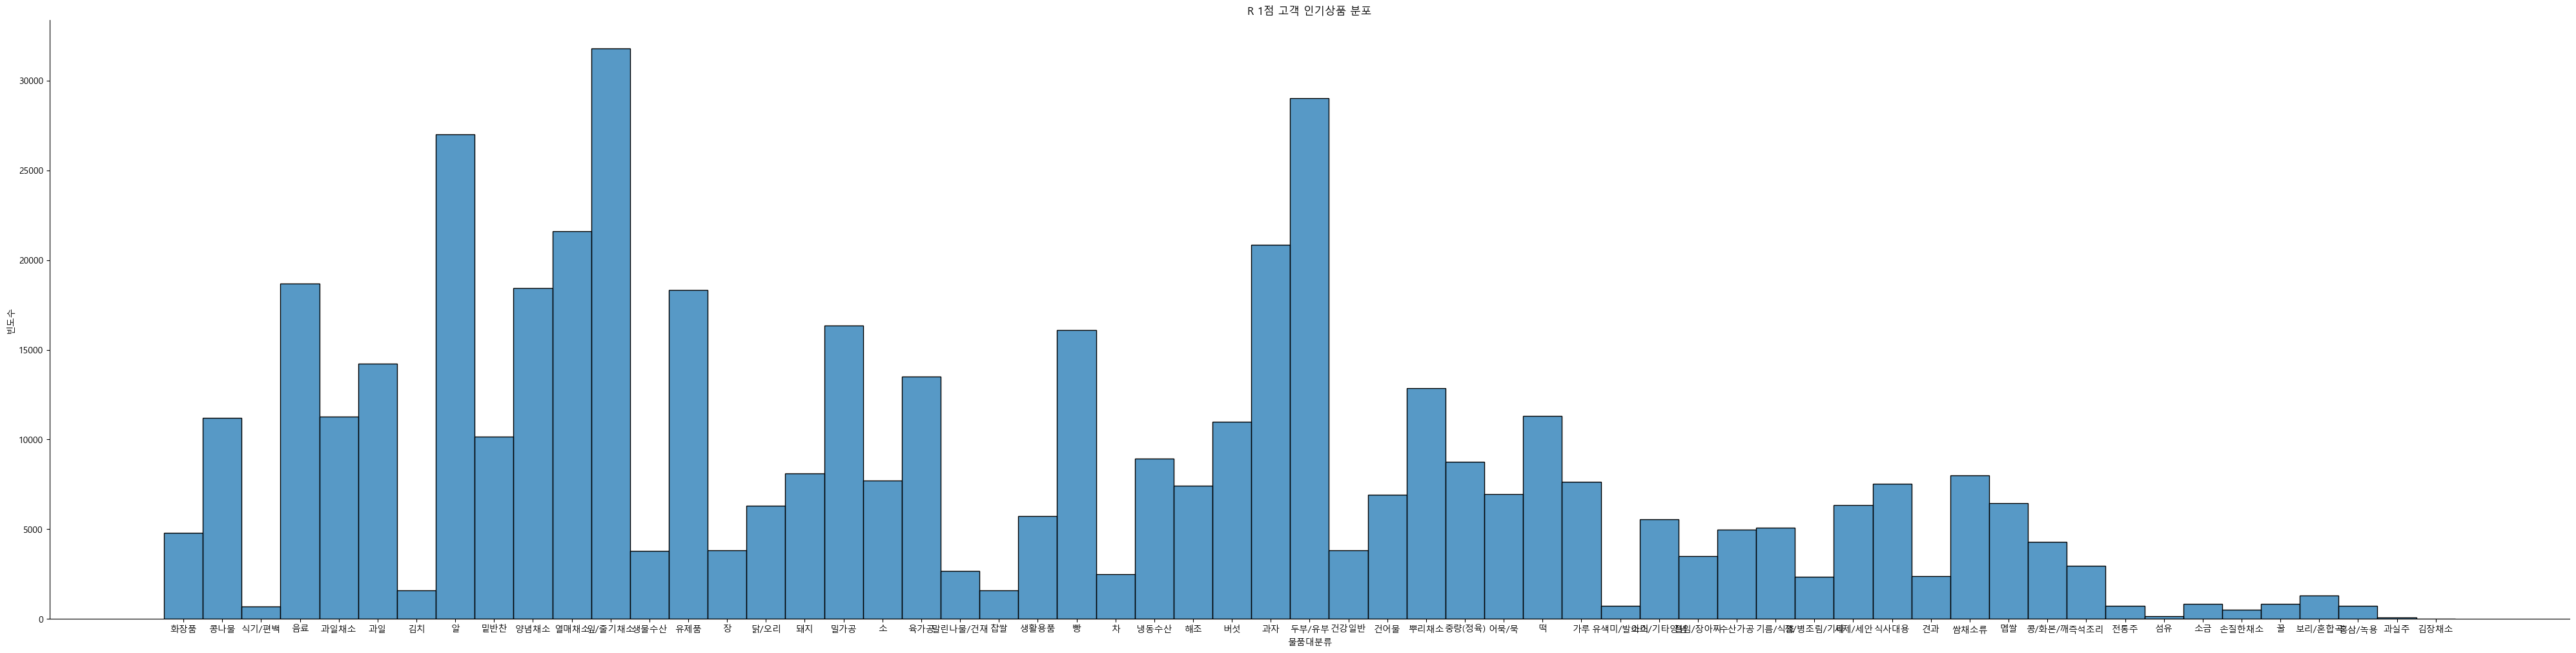

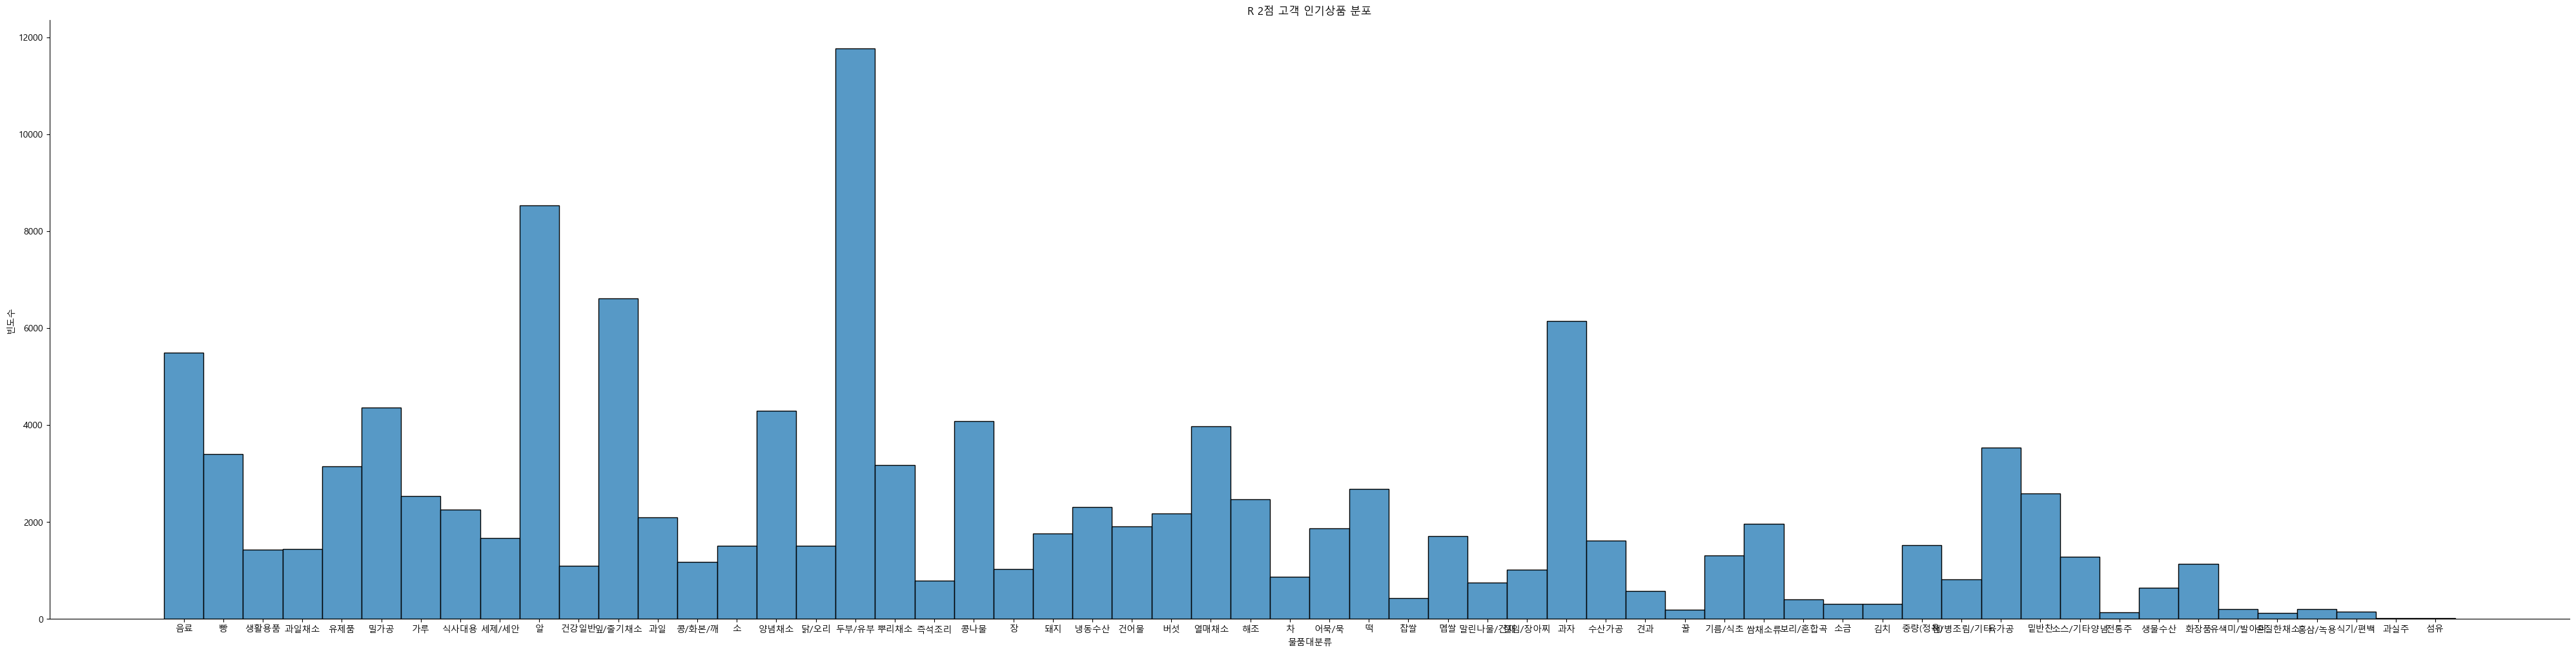

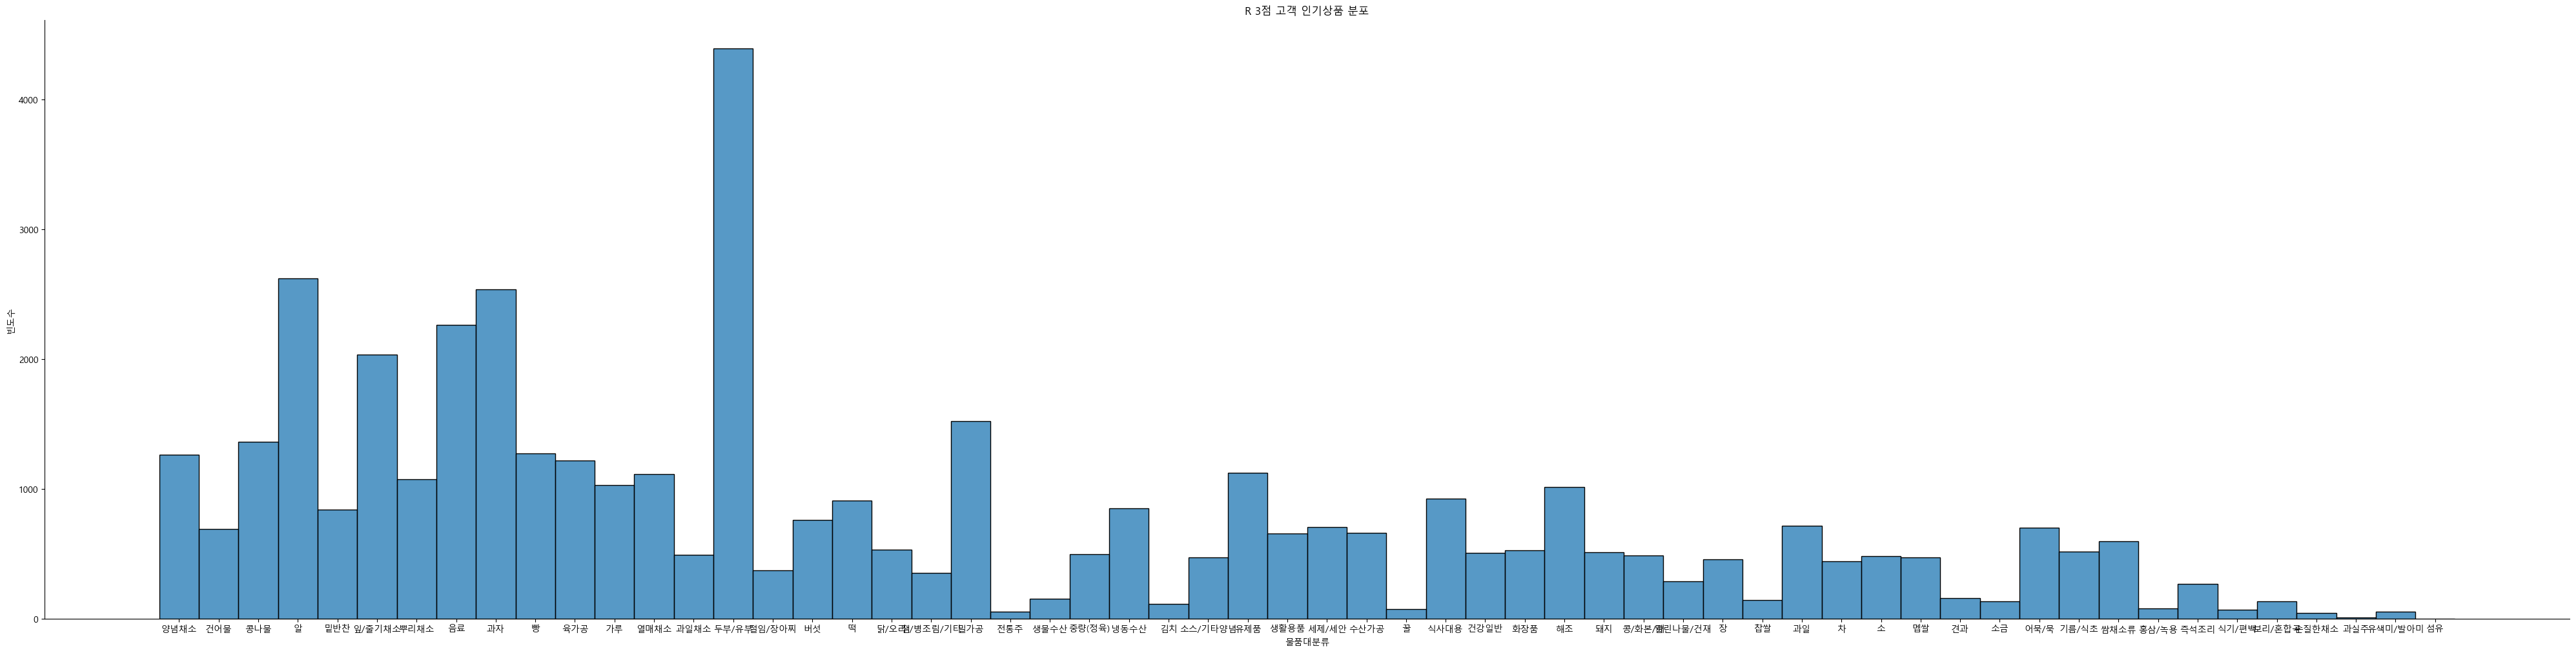

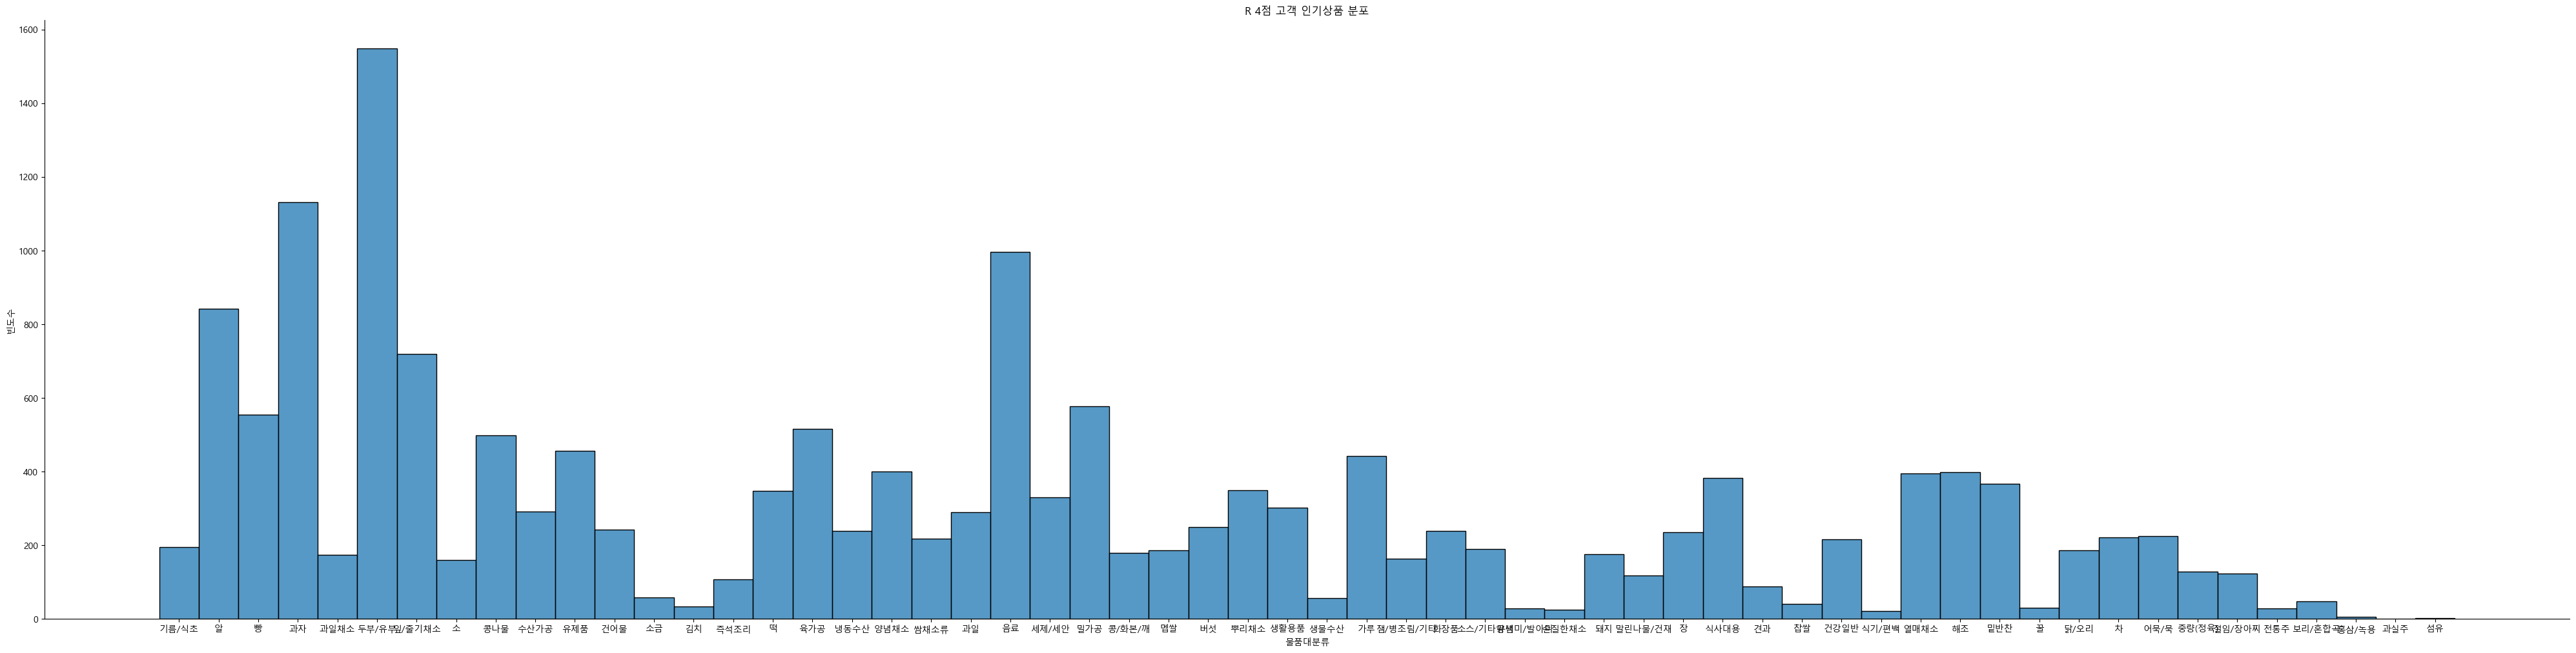

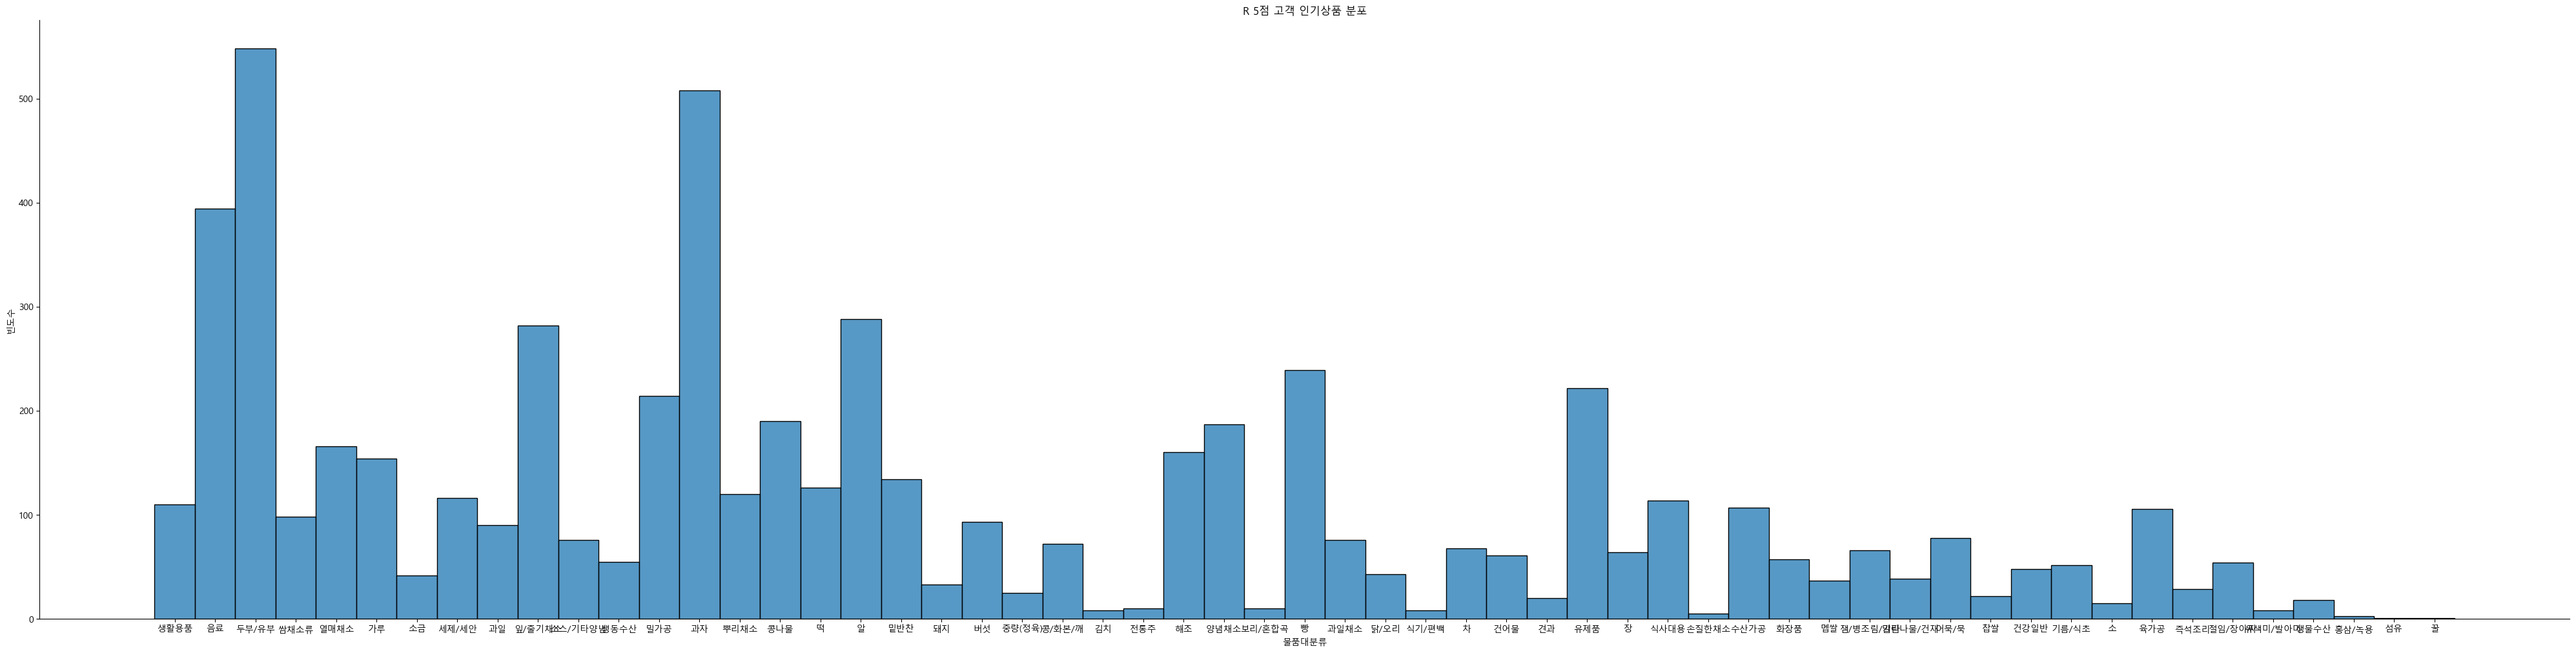

In [223]:
Score_list = [1, 2, 3, 4, 5]

for score in Score_list :
    RFM_cond = df_merged_RFM['R_Score'] == score
    df_RFM_Score = df_merged_RFM.loc[RFM_cond]

    # RFM_Score 점수 별 인기상품 시각화 (X - 물품대분류 / Y - 판매개수)
    sns.displot(data = df_RFM_Score, x = '물품대분류', height=10, aspect=4)
    plt.xlabel('물품대분류')
    plt.ylabel('빈도수')
    plt.title(f'R {score}점 고객 인기상품 분포')

    # 그래프 이미지파일로 저장
    plt.savefig(f'R{score}score_popular_products_image.png')